**Predicting Respiratory Diseases by the Patient’s Breathing Sounds**

Kaarel Tamuri<br>
Stina-Marie Maripuu

Set within the healthcare industry, this project focuses on supporting the diagnostic process for respiratory diseases. It aims to harness the potential of machine learning to analyze breathing sounds, to help cure patients more effectively and reliably.

We are using CNN (Convolutional Neural Network), which is a network architecture for deep learning that learns directly from data

In [17]:
#LIBARIES
!pip install pandas numpy librosa matplotlib tqdm imbalanced-learn scikit-learn tensorflow keras seaborn

In [19]:
#IMPORTS
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
from tqdm import tqdm


from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import metrics  # Import metrics module
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.utils import to_categorical


from datetime import datetime
import seaborn as sns





In [18]:
#All PATHS TO DATA
path_files = "archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
path_diagnose = "archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"
path_demo = "archive\demographic_info.txt"

In [3]:
#.wav filenames
wav_files = []
for file in os.listdir(path_files):
    if file.endswith(".wav"):
        wav_files.append(file)
        
#patient_diagnosis.csv
diagnose = pd.read_csv(path_diagnose, header=None)

#read patient_diagnosis.csv
demo = pd.read_csv("archive\demographic_info.txt", sep="\\s+")
demo.columns = ['patient_nr', 'age', 'sex', 'bmi', 'child_weight', 'child_height']



In [4]:
#Get all file paths
filepaths = []
for i in wav_files:
    path = path_files+i
    filepaths.append(path)


#Find diagnose for every file

file_patient =[]
for i in wav_files:
    pn = int (i[:3])
    file_patient.append(pn)

file_patient = np.array(file_patient)

labels = []
for i in file_patient:
    row = diagnose[diagnose[0] == i]
    labels.append(row[1].values[0])
labels = np.array(labels)




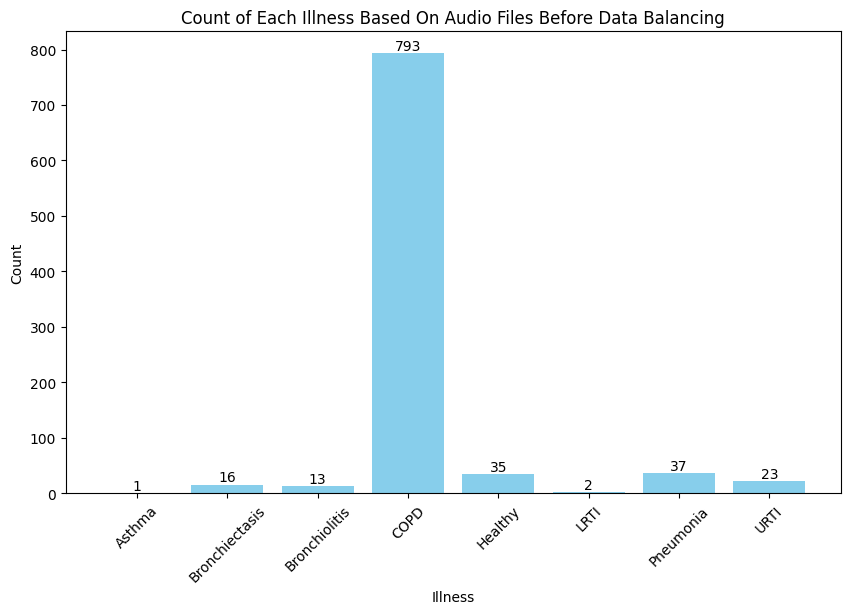

In [5]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(unique_elements, counts_elements, color='skyblue')

# Adding the count labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Illness')
plt.ylabel('Count')
plt.title('Count of Each Illness Based On Audio Files Before Data Balancing')
plt.xticks(rotation=45)
plt.show()

In [6]:
def add_noise(data, noise_level=0.005):
    noise = np.random.randn(len(data))
    return data + noise_level * noise

def time_shift(data, sampling_rate, shift_max=0.2):
    shift_amount = int(sampling_rate * shift_max)
    shift = np.random.randint(-shift_amount, shift_amount)
    return np.roll(data, shift)

def change_pitch(audio, sample_rate, n_steps=2.0, bins_per_octave=12, res_type='soxr_hq', scale=False):
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps, 
                                       bins_per_octave=bins_per_octave, res_type=res_type, scale=scale)

def change_speed(audio, speed_factor=1.2):
    return librosa.effects.time_stretch(y=audio, rate=speed_factor)



def data_augmentation(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    augmented_audio = [
        add_noise(audio),
        time_shift(audio, sample_rate),
        change_pitch(audio, sample_rate),
        change_speed(audio),
    ]
    return augmented_audio, sample_rate



Maximum: 86.2
Minimum: 7.856
Mean: 21.49242430740412
Median: 20.0
90th Percentile: 20.0


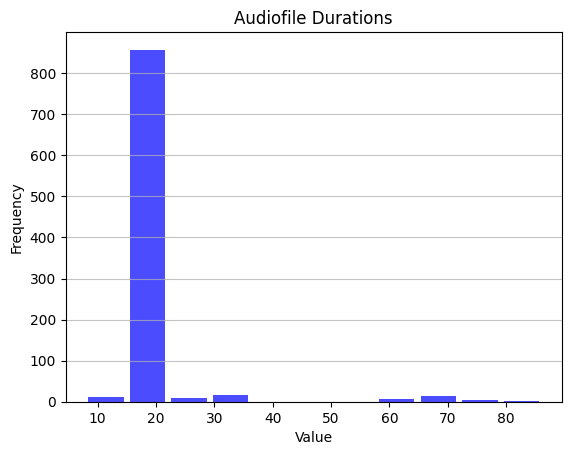

In [7]:
def audioLen(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    duration = len(audio) / sample_rate
    return duration

durations = []
for i in filepaths:
    durations.append(audioLen(i))
    

max_dur = max(durations)
min_dur = min(durations)
mean_dur = np.mean(durations)
median_dur = np.median(durations)
percentile_90 = np.percentile(durations, 90)

# Print the results
print(f"Maximum: {max_dur}")
print(f"Minimum: {min_dur}")
print(f"Mean: {mean_dur}")
print(f"Median: {median_dur}")
print(f"90th Percentile: {percentile_90}")

plt.hist(durations, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.title('Audiofile Durations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()

    
    

In [8]:
#I take 90th Percentile to cover as much as possible, but to not be as slow
durLen = 20
paddingLen = int(np.ceil(durLen*22050/512))


def extract(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=durLen) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = paddingLen - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print(file_path, e)
        return None 

    return mfccs


def extract_features_from_augmented_audio(file_path):
    augmented_audios, sample_rate = data_augmentation(file_path)
    augmented_features = []  # Initialize an empty list to store features
    for aug_audio in augmented_audios:
        mfccs = librosa.feature.mfcc(y=aug_audio, sr=sample_rate, n_mfcc=40)
        pad_width = paddingLen - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        augmented_features.append(mfccs)
    return augmented_features

    

In [9]:
labelsNew = []
featuresNew = []

# Use tqdm for the progress bar
for file_path, label in tqdm(zip(filepaths, labels), total=len(filepaths), desc="Processing files"):
    
    #augment data
    if label not in ["COPD", "LRTI", "Asthma"]:
        augmented_audios, sample_rate = data_augmentation(file_path)
        for aug_audio in augmented_audios:
            mfccs = librosa.feature.mfcc(y=aug_audio, sr=sample_rate, n_mfcc=40)
            pad_width = paddingLen - mfccs.shape[1]
            mfccs_padded = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            featuresNew.append(mfccs_padded)
            labelsNew.append(label)
            
    else:
        mfccs = extract(file_path)
        featuresNew.append(mfccs)
        labelsNew.append(label)

featuresNew = np.array(featuresNew)
labelsNew = np.array(labelsNew)


Processing files: 100%|██████████████████████████████████████████████████████████████| 920/920 [04:41<00:00,  3.27it/s]


In [10]:

features = featuresNew
labels = labelsNew

#We can not train a model, when there are too few samples. 
#Therefore, we do not include Asthma and LTRI.
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 
labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# features per ilness
unique_elements, counts_elements = np.unique(labels1, return_counts=True)

for i in range(len(unique_elements)):
    print("Ilness: "+unique_elements[i]+"; Count: "+str(counts_elements[i]))



Ilness: Bronchiectasis; Count: 64
Ilness: Bronchiolitis; Count: 52
Ilness: COPD; Count: 793
Ilness: Healthy; Count: 140
Ilness: Pneumonia; Count: 148
Ilness: URTI; Count: 92


In [11]:
from imblearn.over_sampling import SMOTE

#One hot
le = LabelEncoder()
labelDummies = le.fit_transform(labels1)  # Change Labels string to int
labelDummiesList = to_categorical(labelDummies)  # Make list by using labelDummies


features = np.reshape(features1, (*features1.shape, 1))

# Make Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(features1, labelDummiesList, stratify=labelDummiesList, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape the features back after SMOTE
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], features1.shape[1], features1.shape[2], 1)


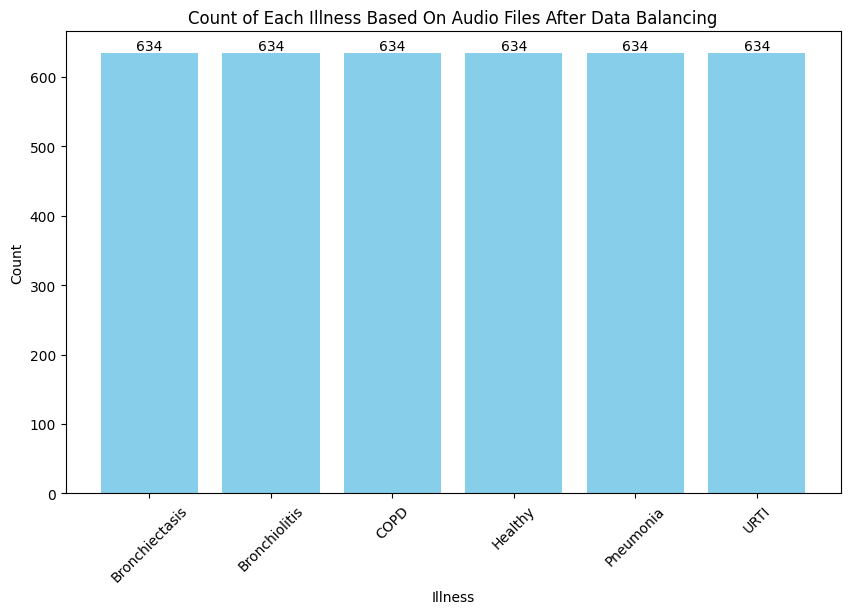

In [12]:
# Convert one-hot encoded labels back to label encoding
y_train_smote_labels = np.argmax(y_train_smote, axis=1)

# Count the occurrences of each class
unique_classes, counts_classes = np.unique(y_train_smote_labels, return_counts=True)

# Map the integer labels back to the original class names
class_names = le.inverse_transform(unique_classes)

    
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts_classes, color='skyblue')

# Adding count labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Illness')
plt.ylabel('Count')
plt.title('Count of Each Illness Based On Audio Files After Data Balancing')
plt.xticks(rotation=45)
plt.show()



In [13]:
rows = 40 #MFCC number
columns = paddingLen #frames
channels = 1

num_labels = labelDummiesList.shape[1]
filter_size = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(rows, columns, channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 


In [14]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', metrics.Recall()], optimizer='adam')


In [21]:
# train model
num_epochs = 100
num_batch_size = 128

model.fit(X_train_smote, y_train_smote, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=1)




Epoch 1/100


30/30 [==============================] - 20s 584ms/step - loss: 4.5452 - accuracy: 0.2116 - recall: 0.1433 - val_loss: 1.8920 - val_accuracy: 0.2791 - val_recall: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 19s 644ms/step - loss: 1.7025 - accuracy: 0.3081 - recall: 0.1120 - val_loss: 1.2721 - val_accuracy: 0.5581 - val_recall: 0.2558
Epoch 3/100
30/30 [==============================] - 20s 661ms/step - loss: 1.4557 - accuracy: 0.3956 - recall: 0.1685 - val_loss: 1.1662 - val_accuracy: 0.6357 - val_recall: 0.4186
Epoch 4/100
30/30 [==============================] - 22s 748ms/step - loss: 1.3354 - accuracy: 0.4419 - recall: 0.2185 - val_loss: 1.1361 - val_accuracy: 0.6473 - val_recall: 0.4574
Epoch 5/100
30/30 [==============================] - 22s 728ms/step - loss: 1.2592 - accuracy: 0.4882 - recall: 0.2526 - val_loss: 0.9791 - val_accuracy: 0.6124 - val_recall: 0.5000
Epoch 6/100
30/30 [==============================] - 21s 715ms/step - loss: 1.1461 -

30/30 [==============================] - 19s 639ms/step - loss: 0.3743 - accuracy: 0.8588 - recall: 0.8278 - val_loss: 0.5972 - val_accuracy: 0.7946 - val_recall: 0.7791
Epoch 44/100
30/30 [==============================] - 19s 636ms/step - loss: 0.3625 - accuracy: 0.8720 - recall: 0.8365 - val_loss: 0.7325 - val_accuracy: 0.7442 - val_recall: 0.7248
Epoch 45/100
30/30 [==============================] - 19s 637ms/step - loss: 0.3674 - accuracy: 0.8649 - recall: 0.8352 - val_loss: 0.6388 - val_accuracy: 0.7674 - val_recall: 0.7481
Epoch 46/100
30/30 [==============================] - 19s 635ms/step - loss: 0.3418 - accuracy: 0.8843 - recall: 0.8536 - val_loss: 0.7173 - val_accuracy: 0.7636 - val_recall: 0.7364
Epoch 47/100
30/30 [==============================] - 19s 637ms/step - loss: 0.3667 - accuracy: 0.8699 - recall: 0.8357 - val_loss: 0.5859 - val_accuracy: 0.8062 - val_recall: 0.7829
Epoch 48/100
30/30 [==============================] - 19s 634ms/step - loss: 0.3104 - accuracy: 0.

Epoch 88/100
30/30 [==============================] - 19s 636ms/step - loss: 0.1367 - accuracy: 0.9535 - recall: 0.9479 - val_loss: 0.4441 - val_accuracy: 0.8837 - val_recall: 0.8798
Epoch 89/100
30/30 [==============================] - 19s 643ms/step - loss: 0.1420 - accuracy: 0.9503 - recall: 0.9422 - val_loss: 0.5098 - val_accuracy: 0.8798 - val_recall: 0.8721
Epoch 90/100
30/30 [==============================] - 20s 658ms/step - loss: 0.1727 - accuracy: 0.9335 - recall: 0.9274 - val_loss: 0.4754 - val_accuracy: 0.8760 - val_recall: 0.8682
Epoch 91/100
30/30 [==============================] - 19s 635ms/step - loss: 0.1467 - accuracy: 0.9443 - recall: 0.9380 - val_loss: 0.4731 - val_accuracy: 0.8837 - val_recall: 0.8682
Epoch 92/100
30/30 [==============================] - 19s 638ms/step - loss: 0.1661 - accuracy: 0.9361 - recall: 0.9277 - val_loss: 0.3655 - val_accuracy: 0.8876 - val_recall: 0.8876
Epoch 93/100
30/30 [==============================] - 20s 678ms/step - loss: 0.1441 -

In [22]:
# Evaluating the model on the training and testing set
train_loss, train_accuracy, train_recall = model.evaluate(X_train_smote, y_train_smote, verbose=1)
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test, verbose=1)

print("Training:")
print("\tAccuracy:", train_accuracy)
print("\tRecall:", train_recall)


print("Testing:")
print("\tAccuracy:", test_accuracy)
print("\tRecall:", test_recall)




9/9 [==============================] - 0s 27ms/step - loss: 0.3854 - accuracy: 0.8837 - recall: 0.8721
Training:
	Accuracy: 0.9437434077262878
	Recall: 0.933491051197052
Testing:
	Accuracy: 0.8837209343910217
	Recall: 0.8720930218696594


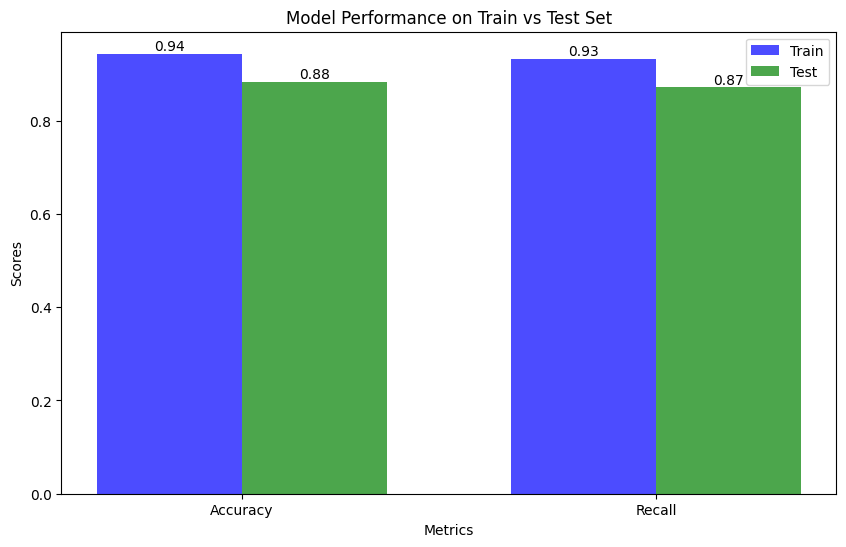

In [23]:
# Data for the bar chart
metrics = ['Accuracy', 'Recall']
train_values = [train_accuracy, train_recall]
test_values = [test_accuracy, test_recall]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Creating the bar chart
plt.figure(figsize=(10, 6))
train_bars = plt.bar(x - width/2, train_values, width, label='Train', color='blue', alpha=0.7)
test_bars = plt.bar(x + width/2, test_values, width, label='Test', color='green', alpha=0.7)

# Adding labels to the bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

add_labels(train_bars)
add_labels(test_bars)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance on Train vs Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.show()

In [24]:
predictions = model.predict(X_test)

predClass = np.argmax(predictions, axis=1)

realClass = np.argmax(y_test, axis=1)



9/9 [==============================] - 0s 27ms/step


In [25]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(unique_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

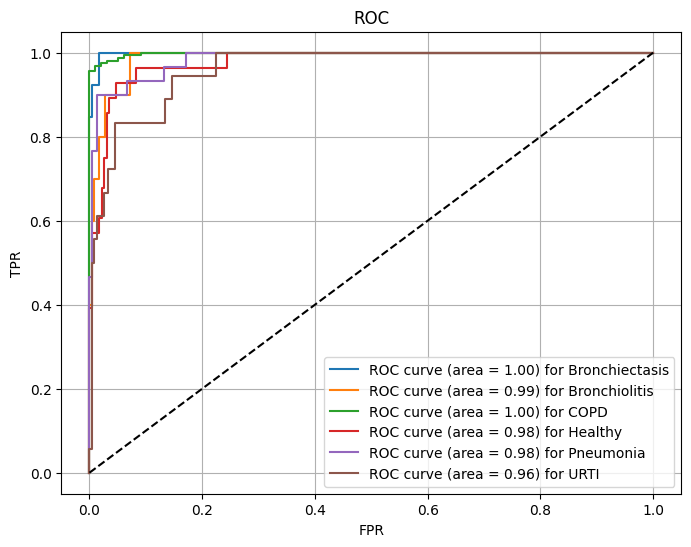

In [51]:
plt.figure(figsize = (8,6))

for i in range(len(c_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {c_names[i]}')
    
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.grid()
plt.show()


In [28]:
print(classification_report(realClass, predClass, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       0.80      0.92      0.86        13
 Bronchiolitis       0.53      0.90      0.67        10
          COPD       1.00      0.94      0.97       159
       Healthy       0.82      0.64      0.72        28
     Pneumonia       0.82      0.90      0.86        30
          URTI       0.57      0.67      0.62        18

      accuracy                           0.88       258
     macro avg       0.76      0.83      0.78       258
  weighted avg       0.90      0.88      0.89       258

